In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import os
from collections import Counter
import matplotlib.pyplot as plt
from functools import reduce
from tqdm.notebook import tqdm
from scipy import sparse
import gc
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import xgboost as xgb
from numba import jit
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import numba
from scipy.sparse import csr_matrix
import pickle
from bayes_opt import BayesianOptimization
from functools import partial

Let's have a look at the contents of the zipped files:

In [2]:

for dirname, _, filenames in os.walk('./data'):
    
    for filename in filenames:
        
        pth    = os.path.join(dirname, filename)
        zf     = zipfile.ZipFile(pth)
        size   = sum([zinfo.file_size for zinfo in zf.filelist])
        zip_mb = float(size) / 1000 ** 2  # MB
        
        fields_all = 0
        fields_mis = 0

        for file in zf.filelist:
            with zf.open(file, 'r') as f:
                for zip_line_idx, zip_line in enumerate(f):
                    if zip_line_idx <= 5: # Parse the first lines to check for missing values
                        line = zip_line.decode("utf-8").split(',')           # Convert to string and split elements
                        fields_mis += np.sum([field == '' for field in line]) # Get no. fields missing
                        fields_all += len(line)                               # Get total no. fields
        
        # Print info
        print(f'Path:\t{pth}')
        print(f'Name:\t {zf.namelist()}')
        print(f'Size:\t {zip_mb} MB')
        print(f'Rows:\t {zip_line_idx}')
        print(f'% Mis:\t {round(fields_mis / fields_all * 100, 3)}')

Path:	./data\sample_submission.csv.zip
Name:	 ['sample_submission.csv']
Size:	 11.281556 MB
Rows:	 1183748
% Mis:	 0.0
Path:	./data\test_categorical.csv.zip
Name:	 ['test_categorical.csv']
Size:	 2678.272381 MB
Rows:	 1183748
% Mis:	 80.126
Path:	./data\test_date.csv.zip
Name:	 ['test_date.csv']
Size:	 2893.227216 MB
Rows:	 1183748
% Mis:	 65.802
Path:	./data\test_numeric.csv.zip
Name:	 ['test_numeric.csv']
Size:	 2137.286201 MB
Rows:	 1183748
% Mis:	 65.635
Path:	./data\train_categorical.csv.zip
Name:	 ['train_categorical.csv']
Size:	 2678.343036 MB
Rows:	 1183747
% Mis:	 81.784
Path:	./data\train_date.csv.zip
Name:	 ['train_date.csv']
Size:	 2893.367134 MB
Rows:	 1183747
% Mis:	 68.655
Path:	./data\train_numeric.csv.zip
Name:	 ['train_numeric.csv']
Size:	 2139.901506 MB
Rows:	 1183747
% Mis:	 67.285


So, we have 1183747 rows for train and 1183748 for test, and the train / test files seem to be aligned in terms of rows.
Moveover, by scanning through the first 50k lines on each file, it is clear that the dataset is sparse.
train and test date files: 82% missing
train and test numerical files: 81% missing
train and test categorical files: 97% missing.

We should probably move to a sparse storage / loading format.

# Headers

In [3]:
datadir = './data/'

date_header = pd.read_csv(datadir + 'train_date.csv.zip', nrows = 1).columns.to_list()
num_header  = pd.read_csv(datadir + 'train_numeric.csv.zip', nrows = 1).columns.to_list()
cat_header  = pd.read_csv(datadir + 'train_categorical.csv.zip', nrows = 1).columns.to_list()
all_header  = date_header + num_header + cat_header
print('Duplicate columns:', [item for item, count in Counter(all_header).items() if count > 1])
print('All columns:', len(set(all_header)))


Duplicate columns: ['Id']
All columns: 4266


So in total we have approximately 1.1 mln rows, 4000 features...

ID should be treated as our index. 

Let's see how many stations, lines and features we have:

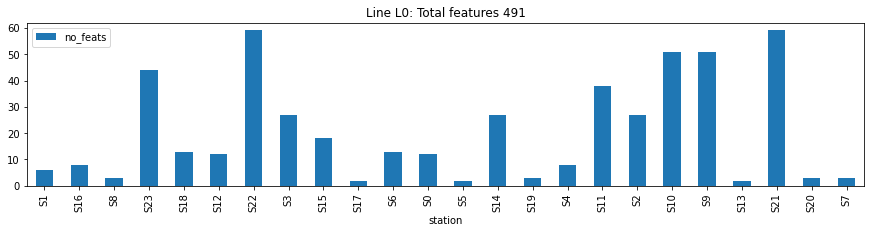

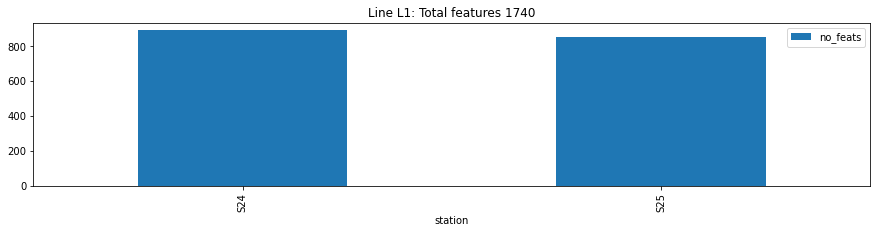

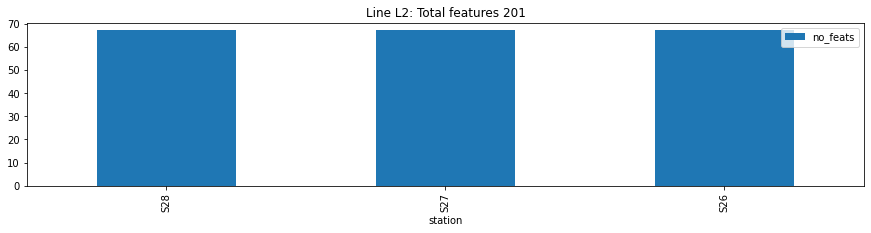

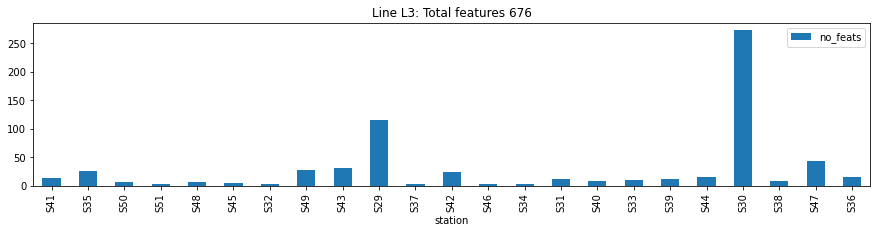

In [4]:
def extract_line(colname):    return colname.split('_')[0]
def extract_station(colname): return colname.split('_')[1]
def extract_feature(colname): return colname.split('_')[2]

feat_headers = [header for header in num_header + cat_header if header != 'Id' and header != 'Response']

feat_counter = []

lines = set([extract_line(header) for header in feat_headers])
for line in lines:
    stations = set([extract_station(header) for header in feat_headers if extract_line(header) == line])
    for station in stations:
        feats = [extract_feature(header) for header in feat_headers if extract_line(header) == line and extract_station(header) == station]
        feat_counter.append((line, station, len(feats)))
        
f = pd.DataFrame(feat_counter, columns=['line', 'station', 'no_feats'])
for line, group in f.groupby('line'):
    
    total_feats = sum(group['no_feats'])
    group.plot(kind = 'bar', x = 'station', y = 'no_feats', figsize = (15, 3), title = f'Line {line}: Total features {total_feats}')

It might be a good idea to have a look at the data per Line. In the case of Line L1 (with 1740 features), we could go a level deeper and check on a per-station level.

We need a function to load an entire csv without running out of memory (sparse dataframe)

In [109]:
# Function to load a dataframe from an input file
def load_df(input_file, d_type, fill_value, chunksize):
    
    no_rows = 1183747 # This corresponds to the training set. The test set has one additional element
    reader = pd.read_csv(input_file, chunksize = chunksize, engine = 'c', compression = 'zip', index_col = 'Id', dtype = d_type)

    dfs = []

    for df_chunk in tqdm(reader, total = no_rows // chunksize + 1):
        dfs.append(df_chunk.astype(pd.SparseDtype(d_type, fill_value = fill_value)))

    df = pd.concat(dfs, axis = 0)
    
    df.index = df.index.astype(int)

    return df

In [110]:
df_num = load_df(input_file = datadir + 'train_numeric.csv.zip', d_type = np.float64, fill_value = np.nan, chunksize = 200000)
y      = df_num['Response'].values
df_num.drop('Response', axis = 1, inplace = True)

  0%|          | 0/6 [00:00<?, ?it/s]

## Response

In [7]:
print(f"No. positive: {np.sum(y == 1)}")
print(f"No. negative: {np.sum(y == 0)}")
print(f"Ratio [%]: {np.sum(y == 1) / np.sum(y == 0)*100}")

No. positive: 6879
No. negative: 1176868
Ratio [%]: 0.5845175499716195


Highly imbalanced

## Make KFold sets and holdout set


In [8]:
# Train/test split of sklearn takes quite a bit of time
# The following is faster to get a stratified train/test split
def train_test_split(y, test_ratio):
    
    # Grab indices of positive and negative responses
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    # Shuffle them
    np.random.seed(220)
    pos_idx = np.random.permutation(pos_idx)

    np.random.seed(220)
    neg_idx = np.random.permutation(neg_idx)

    # Split on train and test sets
    pos_samples = pos_idx.shape[0]
    neg_samples = neg_idx.shape[0]

    # Grab indices for the holdout set
    pos_idx_hold = pos_idx[:np.floor(pos_samples * test_ratio).astype(int)]
    neg_idx_hold = neg_idx[:np.floor(neg_samples * test_ratio).astype(int)]

    # Grab indices for the training set
    pos_idx_train = np.setdiff1d(pos_idx, pos_idx_hold)
    neg_idx_train = np.setdiff1d(neg_idx, neg_idx_hold)

    # Merge them
    idx_hold  = np.hstack([pos_idx_hold, neg_idx_hold])
    idx_train = np.hstack([pos_idx_train, neg_idx_train])
    
    # Shuffle once more
    np.random.seed(220)
    idx_hold = np.random.permutation(idx_hold)
    np.random.seed(220)
    idx_train = np.random.permutation(idx_train)
    
    return idx_train, idx_hold

In [9]:
# Holdout set
holdout_ratio = 0.1 # Ratio of total for holdout set
no_CV_folds   = 5   # Stratified kfold splits

idx_trainval, idx_hold = train_test_split(y, test_ratio = 0.1)
skf = StratifiedKFold(n_splits = no_CV_folds, random_state = 300, shuffle = True)

In [10]:
# Make holdout set target
y_holdout   = y[idx_hold]

# Make training / validation set target
y_train   = y[idx_trainval]

## Numerical Features
### Missing Values

In [ ]:
# Split train / holdout set
holdout_num = df_num.iloc[idx_hold]
train_num   = df_num.iloc[idx_trainval]

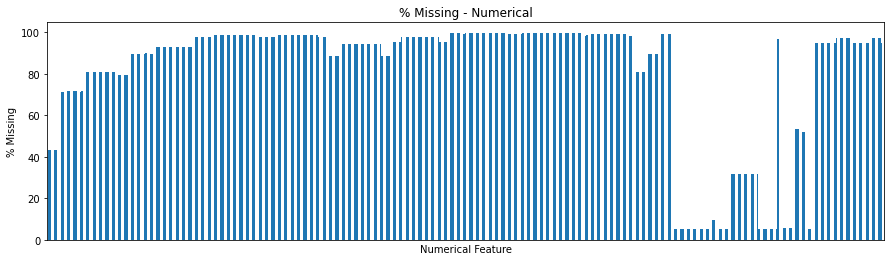

In [11]:
no_samples = train_num.shape[0]

(train_num.isna().sum()/no_samples * 100).plot(kind = 'bar', xticks = [], figsize = (15, 4), 
                                               title = '% Missing - Numerical',
                                               xlabel = 'Numerical Feature',
                                               ylabel = '% Missing');

Quite a lot of variables are missing most of their values. Experimentation with various imputation methods is useless.

### Numerical Feature Importance

We need a quick way to sort through the numerical features and find the most useful ones. We'll do this with xgboost, by fitting a model on 30% of the training set on the first fold:

In [12]:
X = train_num.reset_index() # Use ID as well

# Grab first fold
for trainval_idx, test_idx in skf.split(X, y_train): break

# Subsample the training set and validation sets of the first fold
train_idx, val_idx = train_test_split(y_train[trainval_idx], test_ratio = 0.7)
val_idx,_          = train_test_split(y_train[val_idx], test_ratio = 0.7)

# Make training and validation datasets
X_train, X_val  = X.iloc[train_idx].values, X.iloc[val_idx].values
y_train_        = y[train_idx].to_dense().astype(int)
y_val_          = y[val_idx].to_dense().astype(int)
    
# Fit model
sum_neg, sum_pos = np.sum(y_train_ == 0), np.sum(y_train_ == 1)
xgb = XGBClassifier(n_estimators = 50, use_label_encoder = False, scale_pos_weight = sum_neg / sum_pos)
xgb.fit(X_train, y_train_, 
        eval_set    = [(X_train, y_train_), (X_val, y_val_)],
        eval_metric = 'logloss', 
        verbose     = True)

# Evaluate performance
y_pred = [round(value) for value in xgb.predict(X_val)]
print('Validation Set ROC-AUC: ', roc_auc_score(y_val_, y_pred))    

# Compute feature importance
xgb_imp = pd.DataFrame({'feature' : X.columns, 'importance': xgb.feature_importances_})
xgb_imp.to_csv('./xgb_imp.csv')

C:\Users\kalika01\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


[0]	validation_0-logloss:0.68676	validation_1-logloss:0.68687
[1]	validation_0-logloss:0.67690	validation_1-logloss:0.67698
[2]	validation_0-logloss:0.66744	validation_1-logloss:0.66782
[3]	validation_0-logloss:0.65936	validation_1-logloss:0.65977
[4]	validation_0-logloss:0.64891	validation_1-logloss:0.64960
[5]	validation_0-logloss:0.63440	validation_1-logloss:0.63546
[6]	validation_0-logloss:0.62913	validation_1-logloss:0.63040
[7]	validation_0-logloss:0.61979	validation_1-logloss:0.62119
[8]	validation_0-logloss:0.61614	validation_1-logloss:0.61778
[9]	validation_0-logloss:0.61179	validation_1-logloss:0.61356
[10]	validation_0-logloss:0.60446	validation_1-logloss:0.60642
[11]	validation_0-logloss:0.59871	validation_1-logloss:0.60077
[12]	validation_0-logloss:0.59487	validation_1-logloss:0.59701
[13]	validation_0-logloss:0.58668	validation_1-logloss:0.58914
[14]	validation_0-logloss:0.58275	validation_1-logloss:0.58520
[15]	validation_0-logloss:0.58065	validation_1-logloss:0.58305
[1

C:\Users\kalika01\Anaconda\envs\pytorch_gpu\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Validation Set ROC-AUC:  0.6133061067065692


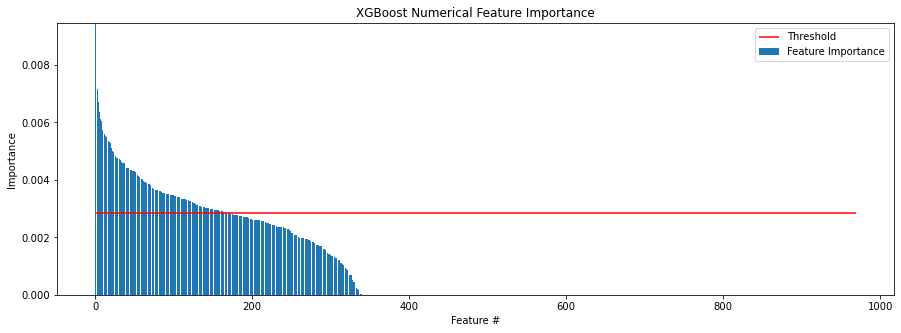

In [13]:
# Plot feature importance and export
file_path = './xgb_imp.csv'
xgb_imp = pd.read_csv(file_path, index_col = 0)
xgb_imp.sort_values(by = 'importance', ascending = False, inplace = True)

fig = plt.figure(figsize = (15, 5))
plt.bar(np.arange(xgb_imp.shape[0]), xgb_imp['importance'])
plt.hlines(xgb_imp['importance'].max() * 0.3, xmin = 0, xmax = xgb_imp.shape[0], color = 'red')
plt.title('XGBoost Numerical Feature Importance');
plt.ylabel('Importance');
plt.xlabel('Feature #');
plt.ylim([0, xgb_imp['importance'].max()]);
plt.legend(['Threshold', 'Feature Importance']);

Bottom line, we can throw away 2/3 of the numerical features directly, but we could reduce even more by dropping everything below a threshold (0.3 of the max value for instance above)

In [14]:
num_feats_to_keep = xgb_imp[xgb_imp['importance'] >= 0.3 * xgb_imp['importance'].max()]

### Retained Numerical Features - EDA

In [15]:
# Keep only the features identified above
train_num = train_num[num_feats_to_keep['feature']]

In [16]:
for line in ['L0', 'L1', 'L2', 'L3']:
    line_feats = np.sum([line in col for col in train_num.columns])
    print(f"Line {line}: {line_feats} features")

Line L0: 63 features
Line L1: 38 features
Line L2: 13 features
Line L3: 56 features


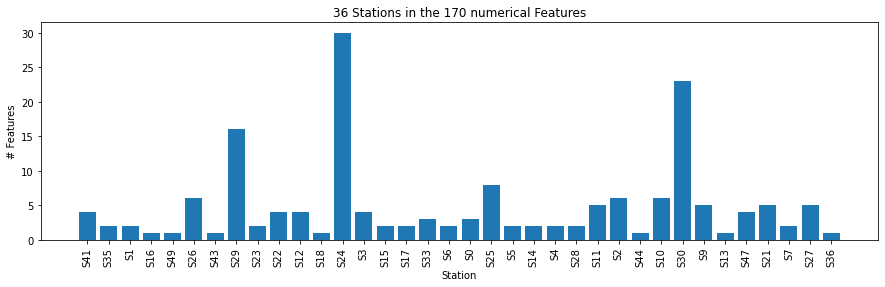

In [17]:
stations = list(set([col.split('_')[1] for col in train_num.columns if 'S' in col ]))

station_feats = []
for station in stations:
    station_feats.append(np.sum([station == col.split('_')[1] for col in train_num.columns]))
    
plt.figure(figsize = (15, 4))
plt.bar(stations, station_feats);
plt.title(f"{len(stations)} Stations in the {len(train_num.columns)} numerical Features");
plt.xlabel('Station');
plt.ylabel('# Features');
plt.xticks(rotation = 90);


We have all 4 lines represented in the subset of numerical features, and around 15 stations. 
### Missing values
Let's have a closer look at missing values

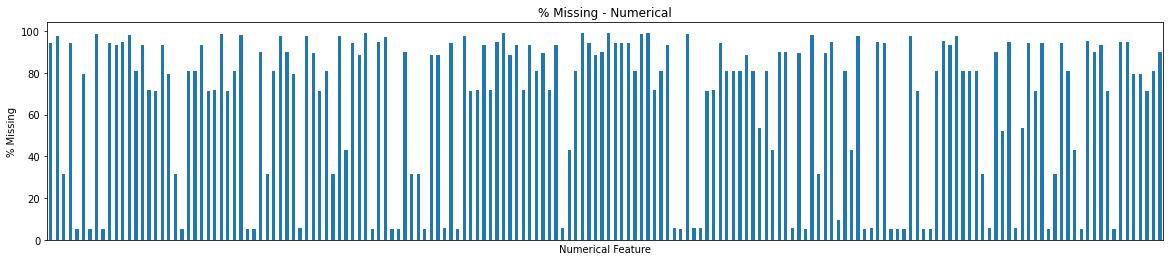

In [18]:
no_samples = train_num.shape[0]

(train_num.isna().sum()/no_samples * 100).plot(kind = 'bar', xticks = [], figsize = (20, 4), 
                                               title = '% Missing - Numerical',
                                               xlabel = 'Numerical Feature',
                                               ylabel = '% Missing');

There are still features with very high number of missing values. The pattern of missing values possibly holds some valuable information.

Let's have a look at the missing data patterns between the different numerical features

In [19]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    
    pairs_to_drop = set()
    cols          = df.columns
    
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    
    return pairs_to_drop

def get_correlations(df):
    
    au_corr = df.corr().unstack()
    to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = to_drop).sort_values(ascending = False).reset_index()
    au_corr.columns = ['feat1', 'feat2', 'corr']
    
    return au_corr

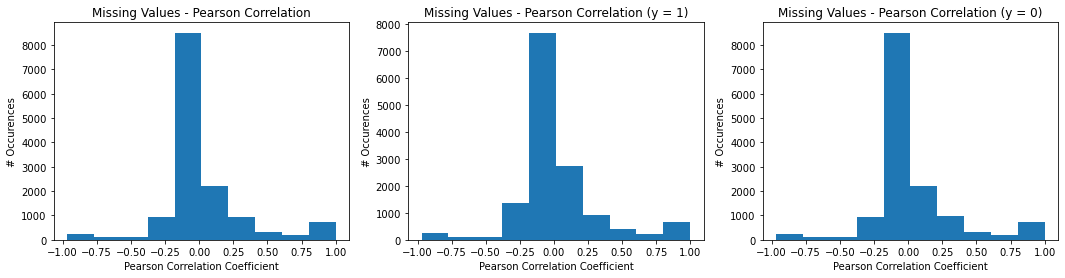

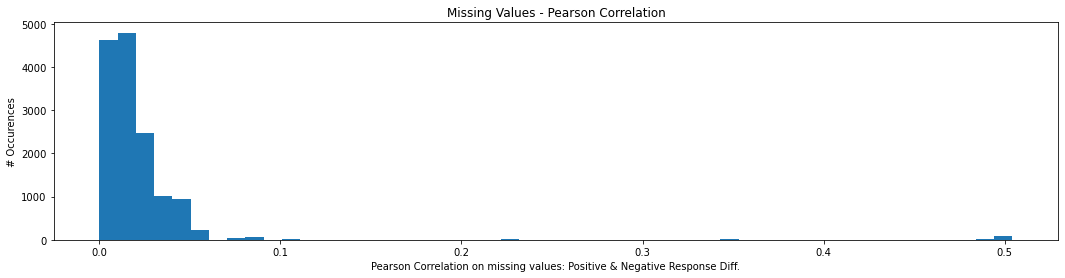

In [20]:
# Make binary matrices indicating nans
num_nan     = train_num.isnull()

# Compute Pearson correlation for all, and positive / negative response separately

nan_pos_corr = get_correlations(num_nan[y_train == 1])
nan_neg_corr = get_correlations(num_nan[y_train == 0])
nan_corr     = get_correlations(num_nan)

# Save in case we nee them
nan_pos_corr.to_csv('./nan_pos_corr.csv')
nan_neg_corr.to_csv('./nan_neg_corr.csv')
nan_corr.to_csv('./nan_corr.csv')

nan_corr = pd.concat([nan_corr.set_index(['feat1', 'feat2']), 
                      nan_pos_corr.set_index(['feat1', 'feat2']), 
                      nan_neg_corr.set_index(['feat1', 'feat2'])], 
                     axis = 1)

nan_corr.columns = ['corr_all', 'corr_pos', 'corr_neg']

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 4))
ax1.hist(nan_corr['corr_all']);
ax1.set_xlabel('Pearson Correlation Coefficient')
ax1.set_ylabel('# Occurences')
ax1.set_title('Missing Values - Pearson Correlation');

ax2.hist(nan_corr['corr_pos']);
ax2.set_xlabel('Pearson Correlation Coefficient')
ax2.set_ylabel('# Occurences')
ax2.set_title('Missing Values - Pearson Correlation (y = 1)');

ax3.hist(nan_corr['corr_neg']);
ax3.set_xlabel('Pearson Correlation Coefficient')
ax3.set_ylabel('# Occurences')
ax3.set_title('Missing Values - Pearson Correlation (y = 0)');

plt.figure(figsize = (18, 4))
plt.hist(np.abs(nan_corr['corr_pos'] - nan_corr['corr_neg']), bins = 50);
plt.xlabel('Pearson Correlation on missing values: Positive & Negative Response Diff.')
plt.ylabel('# Occurences')
plt.title('Missing Values - Pearson Correlation');


There are a few variable pairs which seem to be missing together most of the time (Pearson coefficient equal to 1), and variable pairs which miss alternately (Pearson coefficient equal to -1). Furthermore, there are a few variable pairs for which the Pearson coefficients are very different for the two different responses.
Missing data patterns are very important here. We could add new features, but XGBoost can handle this logic internally.

Considering features with similar missing data patterns (Pearson correlation higher than 0.95), we can also check if their values are correlated:

In [21]:

# Grab feature pairs with highly correlated missing values (>= 0.95 Pearson correlation)
feats_mis_2 = nan_corr[nan_corr['corr_all'] >= 0.95].reset_index()[['feat1', 'feat2']].values

# Empty array to hold results for Spearman rank coefficient
spearman_vals = np.empty((feats_mis_2.shape[0], 1))
idx = 0

# Loop through all the features
for [feat1, feat2] in tqdm(feats_mis_2):
    
    # Grab the two features from the dataframe
    tmp = train_num[[feat1, feat2]].copy().dropna(axis = 0, how = 'any').values
    
    # Compute Spearman rank coefficient
    spearman_vals[idx], _ = spearmanr(tmp[:, 0], tmp[:, 1])
    
    # Increment
    idx += 1

corr_val = pd.DataFrame(np.append(feats_mis_2, spearman_vals, 1), columns = ['feat1', 'feat2', 'corr'])

# Save for later
corr_val.to_csv('./corr_val.csv')


  0%|          | 0/643 [00:00<?, ?it/s]

Let's remove any highly correlated features:

In [22]:
corr_val = pd.read_csv('./corr_val.csv', index_col = 0)

# Compute absolute correlations
corr_val['abs_corr'] = corr_val['corr'].abs()

# Grab the redundant features
feats_to_remove = list(set(corr_val[corr_val['abs_corr'] >= 0.95]['feat2'].to_list()))

# Remove them
to_drop = [col for col in feats_to_remove if col in train_num.columns]
train_num.drop(to_drop, axis = 1, inplace = True)
holdout_num = holdout_num[train_num.columns]


We've reduced the numerical features from approximately 1000 to 263. Not bad
### Duplicates

Let's have a look if there are any duplicate rows in the numerical features. With over 1 million rows it wouldn't be surprising

In [23]:
# Get indices of duplicate rows
dup_ids = train_num.duplicated(keep = False)
print(f'No Duplicate rows in numerical features: {np.sum(dup_ids) // 2}')

No Duplicate rows in numerical features: 30873


Let's have a closer look at those. Perhaps removing them will make the class imbalance more severe:

In [24]:
num_dupes = train_num.loc[dup_ids.index[dup_ids == True]]
num_dupes.insert(loc = 0, column = 'Response', value = y_train[dup_ids == True])
num_dupes[num_dupes['Response'] == 1].sort_index().head()

C:\Users\kalika01\Anaconda\envs\pytorch_gpu\lib\site-packages\IPython\core\interactiveshell.py:3361: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


,Response,L1_S24_F1713,L1_S25_F2016,L3_S30_F3589,L1_S24_F1609,L3_S29_F3433,L0_S12_F342,L3_S30_F3774,L1_S24_F1441,L3_S29_F3461,...,L0_S22_F586,L0_S2_F60,L3_S29_F3339,L3_S47_F4153,L3_S47_F4138,L0_S12_F350,L0_S12_F346,L0_S6_F132,L0_S11_F302,L0_S18_F439
Id,,,,,,,,,,,,,,,,,,,,,
1250,1.0,NaN,NaN,0.035,NaN,-0.076,NaN,-0.071,NaN,-0.040,...,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,-0.131,NaN
1793,1.0,NaN,NaN,-0.045,NaN,0.053,NaN,0.021,NaN,0.017,...,NaN,NaN,-0.012,NaN,NaN,NaN,NaN,-0.112,NaN,NaN
3585,1.0,NaN,NaN,NaN,NaN,0.065,NaN,0.091,NaN,0.417,...,NaN,NaN,0.256,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4978,1.0,NaN,NaN,0.175,NaN,-0.076,NaN,-0.056,NaN,-0.040,...,NaN,NaN,0.079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5017,1.0,0.166,NaN,0.115,NaN,-0.002,NaN,-0.061,NaN,-0.040,...,NaN,NaN,0.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Hold on. Rows 2-3 and 4-5 are clearly duplicates with an index difference of 1 (5017 - 5018, and 5177 - 5178). However. the first column (id = 1793) does not have a pair here. Let's find the previous index in the data:

In [25]:
num_dupes.sort_index(inplace = True)
num_dupes.reset_index(inplace = True)
dupe_pair = num_dupes[(num_dupes['Id'] >= 1790) & (num_dupes['Id'] <= 1800)].sort_index()
dupe_pair

C:\Users\kalika01\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,Id,Response,L1_S24_F1713,L1_S25_F2016,L3_S30_F3589,L1_S24_F1609,L3_S29_F3433,L0_S12_F342,L3_S30_F3774,L1_S24_F1441,...,L0_S22_F586,L0_S2_F60,L3_S29_F3339,L3_S47_F4153,L3_S47_F4138,L0_S12_F350,L0_S12_F346,L0_S6_F132,L0_S11_F302,L0_S18_F439
48,1793,1.0,NaN,NaN,-0.045,NaN,0.053,NaN,0.021,NaN,...,NaN,NaN,-0.012,NaN,NaN,NaN,NaN,-0.112,NaN,NaN
49,1794,0.0,NaN,NaN,-0.045,NaN,0.053,NaN,0.021,NaN,...,NaN,NaN,-0.012,NaN,NaN,NaN,NaN,-0.112,NaN,NaN


Indeed, these two rows seem to be exactly the same apart from the response. Let's verify:

In [26]:
all(dupe_pair.drop(['Id', 'Response'], axis = 1).fillna(0).diff().iloc[1] == 0)

True

Indeed. Apart from the response (and the index) these two rows are equal. Let's see if this occurs somewhere else as well:

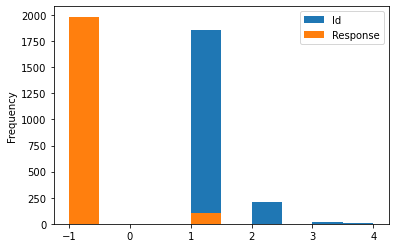

In [27]:
dupes_x = (num_dupes.drop(['Id', 'Response'], axis = 1).fillna(0).diff().T == 0).all()
dupes_y = num_dupes['Response'].diff().T != 0
idx     = np.where(dupes_x & dupes_y)[0].tolist()
idx.extend([elem - 1 for elem in idx])

idx     = np.sort(idx)
num_dupes[['Id', 'Response']].iloc[idx].diff()[1::2].plot.hist();


Yes, this happens throughout. So, we have confirmed that: Duplicate rows of the numeric features with an Id difference of +1 are very likely to have flipped response values.

Does this apply to non-duplicate rows as well?

In [28]:
idr = pd.DataFrame(data = np.vstack([train_num.index.values, y_train]).T, 
                   columns = ['Id', 'Response'])
idr.sort_values(by = 'Id', inplace = True)
idr = idr.diff()[1::2]

print(idr[idr['Id'] == 1]['Response'].value_counts())

 0.0    236986
-1.0      1271
 1.0      1265
Name: Response, dtype: int64


No, not really. Transitions from a zero response, to a unity response or vice versa are pretty much the same.
Now, we need to encode this info on a set of features

In [29]:
# Make a column indicating if a row is a duplicate
new_feats = df_num[train_num.columns].duplicated(keep = False).to_frame()
new_feats.columns = ['dupe']

# First-order differencing on index
new_feats['diffId'] = new_feats.index
new_feats['diffId'] = new_feats['diffId'].diff()

# Flag the second appearance of each duplicate row
new_feats['dupe_second_occur'] = df_num[train_num.columns].duplicated(keep = 'first')

# Add features
train_num   = pd.concat([train_num, new_feats.iloc[idx_trainval]], axis = 1)
holdout_num = pd.concat([holdout_num, new_feats.iloc[idx_hold]], axis = 1)


Let's add second order and interaction terms:

In [17]:
train_num   = train_num.iloc[:, 0:167]
holdout_num = holdout_num.iloc[:, 0:167]

In [27]:
# Multiply with 1e2 the initial features as everything is between 0 and 1
num_cols    = 164
train_num.iloc[:, 0:num_cols] = train_num.iloc[:, 0:num_cols] * 100
holdout_num.iloc[:, 0:num_cols] = holdout_num.iloc[:, 0:num_cols] * 100

# Make second order polynomial features
tmp         = train_num.iloc[:, 0:num_cols] ** 2
tmp.columns = [col + '_sq' for col in tmp.columns]
train_num   = pd.concat([train_num, tmp], axis = 1)

tmp         = holdout_num.iloc[:, 0:num_cols] ** 2
tmp.columns = [col + '_sq' for col in tmp.columns]
holdout_num = pd.concat([holdout_num, tmp], axis = 1)

## Date Features

In [97]:
df_date = load_df(input_file = datadir + './train_date.csv.zip', d_type = np.float64, fill_value = np.nan, chunksize = 200000)

  0%|          | 0/6 [00:00<?, ?it/s]

Let's remove any constant columns:

In [98]:
cols_drop = df_date.columns[df_date.nunique() <= 1]
df_date.drop(cols_drop, axis = 1, inplace = True)

### Record duration

Let's compute duration of each record (max - min) date time, starting time (min time), as well as transition times between consecutive stations. 
We'll do so in chunks so as not to run out of memory:

In [99]:
na_count = df_date.isnull().sum(axis = 1).values
nonna    = df_date.shape[1] - na_count

# Empty arrays to hold results
dur  = np.empty((df_date.shape[0]))
min_ = np.empty((df_date.shape[0]))

# Chunksize for the computation
chunk_size = int(df_date.shape[0] / 20)

for start in tqdm(range(0, df_date.shape[0], chunk_size)):
    df_subset = df_date.iloc[start:start + chunk_size]
    dur[start:start + chunk_size]  = (df_subset.max(axis = 1) - df_subset.min(axis = 1)).values
    min_[start:start + chunk_size] = df_subset.min(axis = 1).values

  0%|          | 0/21 [00:00<?, ?it/s]

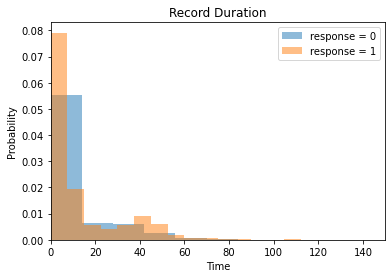

In [100]:
plt.hist(dur[y == 0], 50, density = True, alpha = 0.5);
plt.hist(dur[y == 1], 50, density = True, alpha = 0.5);
plt.title('Record Duration');
plt.ylabel('Probability')
plt.xlabel('Time');
plt.xlim([0, 150]);
plt.legend(['response = 0', 'response = 1']);

There's not that much of a difference. Perhaps duration divided by the number of recorded features might be more informative:

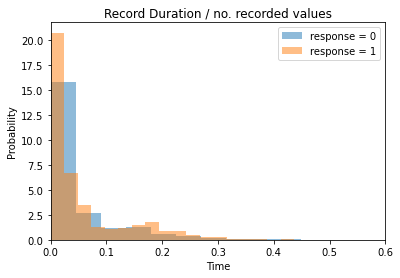

In [101]:
plt.hist(dur[y == 0] / nonna[y == 0], 100, density = True, alpha = 0.5);
plt.hist(dur[y == 1] / nonna[y == 1], 100, density = True, alpha = 0.5);
plt.title('Record Duration / no. recorded values');
plt.ylabel('Probability')
plt.xlabel('Time');
plt.xlim([0, 0.6]);
plt.legend(['response = 0', 'response = 1']);

### Station transition sequence
Let's also encode the entire station-by-station sequence. Perhaps this holds useful info:

In [102]:
def station_seq(date_df_row):
    
    # Sort by time and get index (original df column: line_station_feature)
    date_df_row = date_df_row.sort_values().dropna().to_frame().drop_duplicates().index
    
    # Make a sequence of stations from the index 
    seq = map(lambda x: str(x.split('_')[1].strip('S')), date_df_row)
    
    # Return unique while keeping order
    seq = list(dict.fromkeys(seq))
    
    return '_'.join(seq)

In [36]:
tqdm.pandas()
transition_seq = df_date.progress_apply(lambda row: station_seq(row), axis = 1)

  0%|          | 0/1183747 [00:00<?, ?it/s]

Let's have a look:

In [105]:
print(f"Unique station transitions: {len(transition_seq.unique())}")

Unique station transitions: 42214


One-hot encoding is not the best option here.

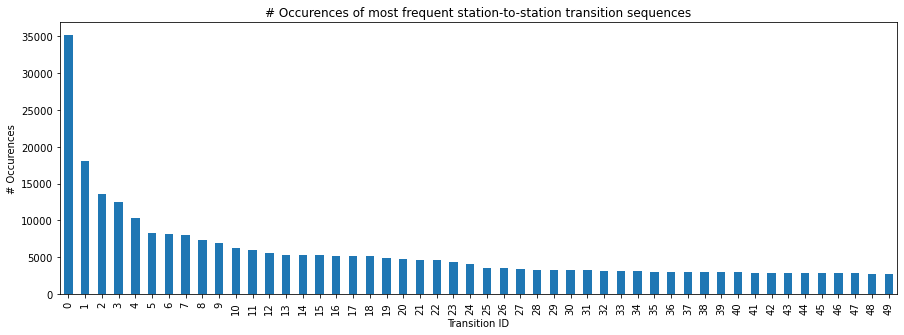

In [38]:
seq_to_plot = 50
transition_seq.value_counts().sort_values(ascending = False).head(seq_to_plot).plot.bar(
    xticks  = np.arange(seq_to_plot), 
    figsize = (15, 5),
    title   = '# Occurences of most frequent station-to-station transition sequences',
    xlabel  = 'Transition ID',
    ylabel  = '# Occurences'
);

Target encoding with additive smoothing is probably a good approach. There is information leak since we're doing this outside of resampling, but with so much data it should not be a problem:

In [39]:
def calc_smooth_mean(df, by, on, m):
    '''
    Credit: https://maxhalford.github.io/blog/target-encoding/
    '''
    
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg    = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means  = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [40]:
# Convert to dataframe and add target
transition_seq = transition_seq.to_frame()
transition_seq.columns   = ['sequence']
transition_seq['target'] = y

# Run encoder
transition_seq['seq_encoded'] = calc_smooth_mean(transition_seq, by = 'sequence', on = 'target', m = 3000)

### Station Duration
Let's also compute duration at each station for each record. This will be defined as the time difference between the first and last recorded feature:

In [108]:
stations = list(set([col.split('_')[1] for col in df_date.columns]))
station_durs = []

for station in stations:
    
    # Grab features referring to this station only
    station_cols = [col for col in df_date.columns if station == col.split('_')[1]]
    df_temp      = df_date[station_cols]
    
    # Compute duration and append
    station_dur  = df_temp.max(axis = 1) - df_temp.min(axis = 1)
    station_dur = station_dur.to_frame()
    station_dur.columns = [station]
    station_durs.append(station_dur)

station_durs = pd.concat(station_durs, axis = 1)

Let's also drop any constant columns that arise from this:

In [110]:
# Get columns containing constant values
cols_to_drop = station_durs.columns[station_durs.nunique() <= 1]

# Drop them
station_durs.drop(cols_to_drop, axis = 1, inplace = True)

Alright, let's make the new dataframe with all the date features

In [111]:
# Get station durations
df_date_new = station_durs.copy()

# Add otal duration
df_date_new['total_dur'] = dur

# Add initial date
df_date_new['date_min'] = min_

# Add the encoded transition sequence
df_date_new['transition_seq'] = transition_seq['seq_encoded'].values

# Add no missing
df_date_new['na_count'] = na_count

Let's have a closer look at the starting dates. Perhaps there's more info rearding the response (same way there was info in the Id column of the numerical features). 

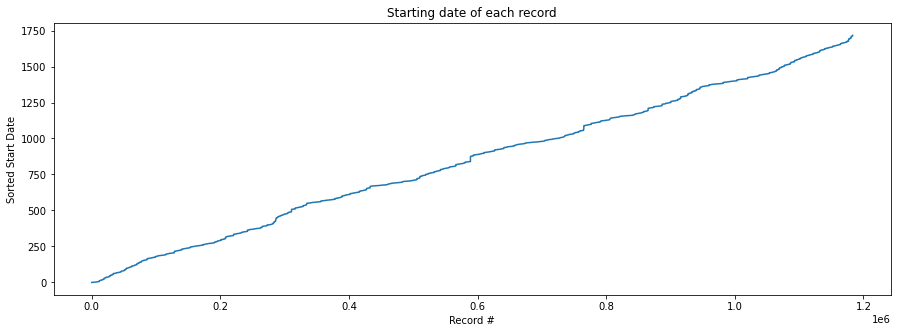

In [112]:
plt.figure(figsize = (15, 5))
plt.plot(np.arange(df_date_new.shape[0]), df_date_new['date_min'].sort_values())
plt.xlabel('Record #');
plt.ylabel('Sorted Start Date');
plt.title('Starting date of each record');

Same starting days seem to be appearing in different records (the small jumps on the graph above). Let's plot the number of occurences of each starting date

Timestamp granularity range: 0.009999999999990905 12.659999999999854
Timestamp granularity median: 0.009999999999990905


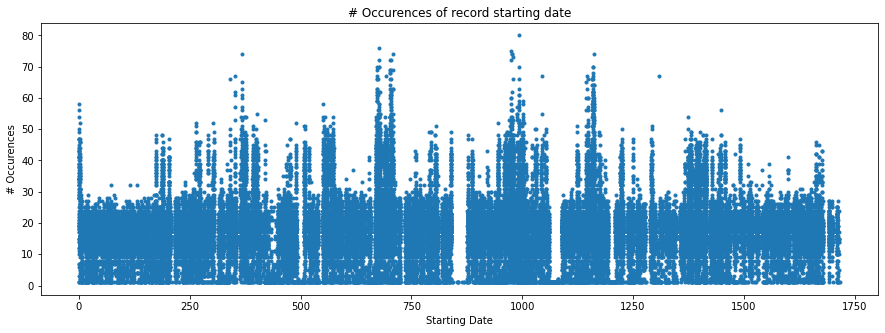

In [113]:
start_dates = df_date_new['date_min'].value_counts().reset_index().sort_values(by = 'index')
start_dates.columns = ['time', 'cnt']

plt.figure(figsize = (15, 5))
plt.scatter(start_dates['time'], start_dates['cnt'], marker = '.')
plt.xlabel('Starting Date');
plt.ylabel('# Occurences');
plt.title('# Occurences of record starting date');
print('Timestamp granularity range:', start_dates['time'].diff().min(), start_dates['time'].diff().max())
print('Timestamp granularity median:', start_dates['time'].diff().median())

We have records every 0.01 units of time, with the big gap in the middle of graph being equal to 12.66 units of time.
There also seems to be some periodicity in the graph. Let's check for autocorrelations:

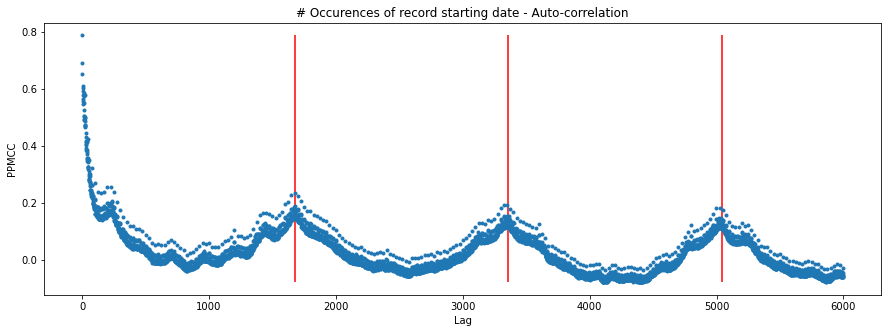

In [114]:
# Make a dataframe with equally spaced times w/ a granularity of 0.01
times_regular = pd.DataFrame(data = np.arange(start_dates['time'].min(), start_dates['time'].max(), 0.01), 
                             columns = ['time'])

# Merge with the value counts & fill NaNs by zero
time_counts = start_dates.merge(times_regular, how = 'right', on = 'time').fillna(0)

# Autocorrelation
x         = time_counts['cnt'].values
max_lag   = 6000
auto_corr = np.array([np.corrcoef(x[: -lag], x[lag:])[0, 1] for lag in range(1, max_lag)])

# Plot
fig = plt.figure(figsize = (15, 5))
plt.plot(auto_corr, '.')
for k in range(1, 4):
    plt.vlines(x = 1680 * k, ymin = auto_corr.min(), ymax = auto_corr.max(), color = 'r')
plt.title('# Occurences of record starting date - Auto-correlation');
plt.ylabel('PPMCC');
plt.xlabel('Lag');


The highest autocorrelation occurs approximately every 1680 units of time (1 unit of time = 0.01). Perhaps day number will be a useful feature:

In [115]:
day_time = 1680 * 0.01 # Units of time in one day(?)
df_date_new['start_day_no'] = df_date_new['date_min'] // day_time
df_date_new['end_day_no']   = (df_date_new['date_min'] + df_date_new['total_dur']) // day_time

In [116]:
# Make train and holdout sets
train_date   = df_date_new.iloc[idx_trainval]
holdout_date = df_date_new.iloc[idx_hold]

## Categorical Features

In [74]:
df_cat = load_df(input_file = datadir + 'train_categorical.csv.zip', d_type = str, fill_value = np.nan, chunksize = 100000)
df_cat.shape

  0%|          | 0/12 [00:00<?, ?it/s]

(1183747, 2140)

An additional 2140 categorical features. Let's check missing data patterns:

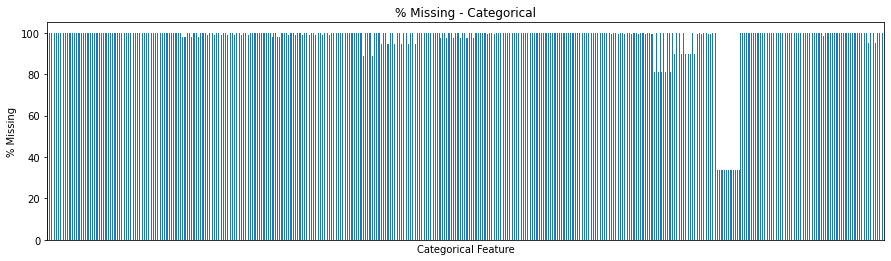

In [75]:
no_samples = df_cat.shape[0]

(df_cat.isna().sum()/no_samples * 100).plot(kind = 'bar', xticks = [], figsize = (15, 4), 
                                            title = '% Missing - Categorical',
                                            xlabel = 'Categorical Feature',
                                            ylabel = '% Missing');

Apart from a few features with 40% missing records, everything else has a missing ratio of more than 80%. Let's drop columns with all missing:

In [76]:
cols_drop = df_cat.columns[df_cat.isna().all()]
df_cat.drop(cols_drop, axis = 1, inplace = True)
df_cat.shape

(1183747, 1977)

We got rid of around 40 columns...
Perhaps we could aggreggate categorical features per station:

The character T appears in every non-nan cell, followed by a number (probably an ID), let's get rid of it and convert the datatype:

In [77]:
df_cat = df_cat.apply(lambda col: col.map(lambda cell: str(cell).lstrip('T') if isinstance(cell, str) else cell))
df_cat = df_cat.astype(float)

We will compute the number of non-missing values on a station level, and we'll drop the original dataframe

In [78]:
# Grab all stations appearing in the categorical features
cat_stations = np.unique([col.split('_')[1] for col in df_cat.columns])

# List to hold results
res = []

for station in tqdm(cat_stations):
    
    # Grab columns for this station
    cols    = [col for col in df_cat.columns if station == col.split('_')[1]]
    
    # Number of non-missing values in each row for this station
    no_nan = df_cat[cols].notna().sum(axis = 1)
    no_nan = no_nan.to_frame()
    no_nan.columns = [station]
    
    res.append(no_nan)
    
df_cat_new = pd.concat(res, axis = 1).astype(int)

# Make train and holdout sets
train_cat   = df_cat_new.iloc[idx_trainval]
holdout_cat = df_cat_new.iloc[idx_hold]

  0%|          | 0/31 [00:00<?, ?it/s]

## Make and save datasets

Let's make a checkpoint here with the final datasets:

In [44]:
# Make datasets
X_train   = csr_matrix( pd.concat( [train_num, train_date, train_cat], axis = 1).values )
X_holdout = csr_matrix( pd.concat( [holdout_num, holdout_date, holdout_cat], axis = 1).values )

In [45]:
# Make checkpoint
save_list = [X_train, X_holdout, y_train, y_holdout, skf]
file_name = "./datasets.pkl"
open_file = open(file_name, "wb")
pickle.dump(save_list, open_file)
open_file.close()

## Modelling

### Load the datasets

In [2]:
# Load checkpoint
file_name = "./datasets.pkl"
open_file = open(file_name, "rb")
X_train, X_holdout, y_train, y_holdout, skf = pickle.load(open_file)
open_file.close()

### Evaluation metric

We need a function to compute the Matthews Correlation Coefficient (MCC) in an efficient way for xgboost. We'll use some numba magic for this, so as to optimise the threshold probability as well:

In [3]:
@jit(nopython = True)
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    
    if inf == 0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit(nopython = True)
def eval_mcc(y_true, y_prob):
    
    # Sort arrays
    idx         = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    
    # Get # samples
    n = y_true.shape[0]
    
    # Get no. positive and no. negative
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    
    best_mcc   = 0.0
    best_id    = -1
    prev_proba = -1
    best_proba = -1
    
    # Initialise array for results
    mccs = np.zeros(n)
    
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        
        if proba != prev_proba:
            
            prev_proba = proba
            new_mcc    = mcc(tp, tn, fp, fn)
            
            if new_mcc >= best_mcc:
                
                best_mcc   = new_mcc
                best_id    = i
                best_proba = proba
                
        mccs[i] = new_mcc
        
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    
    return best_mcc

# Evaluation metric compatible with xgboost api
def mcc_eval(y_prob, dtrain):
    
    y_true   = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    
    return 'MCC', best_mcc

Let't time it:

In [4]:
y_prob0 = np.random.rand(1000000)
y_prob  = y_prob0 + 0.4 * np.random.rand(1000000) - 0.02
y_true  = (y_prob0 > 0.6).astype(int)

%timeit eval_mcc(y_true, y_prob)

del y_prob0, y_prob, y_true
gc.collect();

168 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### k-fold CV

We'll use xgboost as the learning algorithm. Let's write a wrapper to perform k-fold CV and return the average validation MCC:

In [5]:
def CV(X_train, y_train, skf, eta, gamma, max_depth, num_boost_round, subsample, colsample_bytree, alpha, lamda):
    
    # Early stopping
    early_stopping_rounds = 10

    # Make parameter dict for xgboost
    xgb_params = {"nthread": -1, "booster":"gbtree", "objective": "binary:logistic", 
                  "eval_metric": "auc", "tree_method": "hist", "eta": eta, "gamma": gamma, 
                  "max_depth": int(max_depth), "subsample": subsample,
                  "colsample_bytree": colsample_bytree, "alpha": alpha, "lambda": lamda}
    
    # Run CV with the given parameters
    scores = []
    for train_idx, val_idx in skf.split(np.zeros(y_train.shape[0]), y_train):

        # Make train and validation sets for this fold
        X_train_, y_train_ = X_train[train_idx, :], y_train[train_idx]
        X_val_, y_val_     = X_train[val_idx, :], y_train[val_idx]

        # Make dmatrix
        dtrain = xgb.DMatrix(X_train_, y_train_)
        dval   = xgb.DMatrix(X_val_, y_val_)

        # Scale positive instances
        sum_neg, sum_pos = np.sum(y_train_ == 0), np.sum(y_train_ == 1)
        xgb_params["scale_pos_weight"] = sum_neg / sum_pos

        # Train using the parameters
        bst = xgb.train(params = xgb_params,
                        dtrain = dtrain,
                        feval  = mcc_eval,
                        evals  = [ (dtrain, 'train'), (dval, 'eval') ],
                        maximize = True,
                        verbose_eval = False,
                        num_boost_round = int(num_boost_round),
                        early_stopping_rounds = early_stopping_rounds)

        # Grab the best score on the validation set
        scores.append(bst.best_score)
        
    return np.mean(scores)

Now, we can perform hyperparameter tuning:

In [6]:
# Make parameter set for Tree booster
params = {
    "eta": (0.05, 0.3), 
    "gamma": (0, 100),
    "max_depth": (5, 50), 
    "num_boost_round": (10, 100), 
    "subsample": (0.5, 0.95), 
    "colsample_bytree": (0.5, 0.95), 
    "alpha": (0, 10), 
    "lamda": (0, 10)} 

# Function handle
f = partial(CV, X_train, y_train, skf)

optimizer = BayesianOptimization(f, params, random_state = 111)
optimizer.maximize(init_points = 20, n_iter = 10)


|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |   lamda   | max_depth | num_bo... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.2763   |  6.122    |  0.5761   |  0.159    |  76.93    |  2.953    |  11.71    |  12.02    |  0.6891   |
|  2        |  0.2893   |  2.387    |  0.6519   |  0.2977   |  23.77    |  0.8119   |  35.13    |  65.91    |  0.6234   |
|  3        |  0.3089   |  4.662    |  0.5533   |  0.06849  |  90.08    |  7.94     |  42.83    |  83.37    |  0.9459   |
|  4        |  0.2689   |  5.773    |  0.8662   |  0.1553   |  2.745    |  4.541    |  9.74     |  83.55    |  0.814    |
|  5        |  0.3226   |  5.653    |  0.6234   |  0.2996   |  13.8     |  6.154    |  26.83    |  46.45    |  0.8275   |
|  6        |  0.2902   |  3.228    |  0.6802   |  0.1297   |  94.72    |  9.187    |  41.62    |  13.07    |  0.9245   |
|  7        |  0.262    

Let's train the best model on all the data:

In [7]:
# Make dmatrices
dtrain = xgb.DMatrix(X_train, y_train)
dheld  = xgb.DMatrix(X_holdout, y_holdout.to_numpy())

# Scale positive instances
sum_neg, sum_pos = np.sum(y_train == 0), np.sum(y_train == 1)

# Make parameter dict for xgboost
xgb_params = {"nthread": -1, "booster":"gbtree", "objective": "binary:logistic", "eval_metric": "auc", "tree_method": "hist",
              "eta":              optimizer.max["params"]["eta"], 
              "gamma":            optimizer.max["params"]["gamma"], 
              "max_depth":        int(optimizer.max["params"]["max_depth"]), 
              "subsample":        optimizer.max["params"]["subsample"],
              "alpha":            optimizer.max["params"]["alpha"], 
              "lambda":           optimizer.max["params"]["lamda"],
              "colsample_bytree": optimizer.max["params"]["colsample_bytree"],
             "scale_pos_weight" : sum_neg / sum_pos}

# Train using the parameters
clf = xgb.train(params = xgb_params,
                dtrain = dtrain,
                feval  = mcc_eval,
                evals  = [(dtrain, 'train')],
                maximize = True,
                verbose_eval = False,
                num_boost_round = int(optimizer.max["params"]["num_boost_round"]),
                early_stopping_rounds = 10)

Let's predict on the heldout set and compute the MCC:

In [8]:
y_prob = clf.predict(dheld)
print(f"Heldout Set MCC: {round(eval_mcc(y_holdout.to_numpy(), y_prob), 3)}")

Heldout Set MCC: 0.255
